# ML course : Assignment 3 ,  flowers classification with CNN using  YOLOv5
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy.io
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPool2D
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#tf.keras.mixed_precision.set_global_policy('mixed_float16')
np.random.seed(1)
tf.random.set_seed(1)

IMAGES_DIR = '/sise/home/roeiza/jpg/'
img_width, img_height = 224, 224
batch_size = 8
epochs = 15
LR=0.0001

In [2]:
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz' --no-check-certificate
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat' --no-check-certificate

In [3]:
!tar -xzf '102flowers.tgz'

In [36]:
mat = scipy.io.loadmat('/sise/home/roeiza/imagelabels.mat')     # read labels from a MATLAB format to Array
labels=mat['labels'].reshape(-1,1).tolist()
len(labels)

8189

In [37]:
print(min(labels),max(labels))
print(list(np.unique(np.array(labels))))

[1] [102]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [38]:
image_list= sorted(os.listdir(IMAGES_DIR))
image_list[:5]

['image_00002.jpg',
 'image_00003.jpg',
 'image_00010.jpg',
 'image_00011.jpg',
 'image_00014.jpg']

In [39]:
l=[]
y=[]
for idx,i in enumerate(image_list):
  current_idx=int(i.split('_')[1][:5])

  if idx+1 != current_idx:
    assert ('indexing of images and labels do not match ')
  current_label=labels[idx][0]    #   labels are between 1-102 will be LAbelEncoded later
  l.append([idx,i,current_label])
  y.append(current_label)

df_y=pd.DataFrame(y,columns=['label'])
num_classes=df_y['label'].nunique()
print(l[:5])
print('num_classes=',num_classes)

[[0, 'image_00002.jpg', 77], [1, 'image_00003.jpg', 77], [2, 'image_00010.jpg', 77], [3, 'image_00011.jpg', 77], [4, 'image_00014.jpg', 77]]
num_classes= 13


In [40]:
df= pd.DataFrame(l,columns=['id','filename','label'])
df.drop('id',axis=1,inplace=True)
df.to_csv('flower102_labels.csv',index=False)

# VGG

In [ ]:
# #####  verification that label and image match
target_label=102
flower102 = [i[1] for i in l if i[2]==target_label ]
print(len(flower102),'images of label',target_label,flower102)
for i in range(5):
  image_file = IMAGES_DIR + flower102[i]
  image = load_img(image_file,target_size=(img_width, img_height))
  print('label',y[i],image.width,image.height)
  plt.imshow(image)

In [ ]:
# # load all images to array
arr=[]
for i in image_list:
  image_file = IMAGES_DIR + i
  image = load_img(image_file,target_size=(img_width, img_height))
  input_arr = img_to_array(image)
  arr.append(input_arr)
X = np.array(arr)

In [9]:
# Convert labels to zero-based indexing
Y = df_y.values.flatten() - 1  # Subtracting 1 to shift from 1-based indexing to 0-based indexing

# Convert categorical labels to one-hot encoded vectors
Y_HOT = to_categorical(Y)

# Split the data into training and testing subsets
# x_ids: Input samples indices (since splitting on X crashes the notebook), Y_HOT: One-hot encoded labels matrix
x_ids = list(range(len(X)))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(x_ids, Y_HOT, stratify=Y_HOT, test_size=0.25, random_state=42, shuffle=True)
# Further split the training subset into training and validation subsets
X_train_idx, X_valid_idx, y_train, y_valid = train_test_split(X_train_idx, y_train, test_size=0.33, random_state=42, shuffle=True)

# Extracting samples from X
X_train, X_valid, X_test = [], [], []
for i in X_train_idx:
  X_train.append(X[i])
for j in X_valid_idx:
  X_valid.append(X[j])
for k in X_test_idx:
  X_test.append(X[k])

In [10]:
print('df_y',df_y.shape, df_y[-2:])
print('Y',Y.shape,Y[-2:])
print('Y_HOT',Y_HOT.shape,Y_HOT[-2:])

df_y (8189, 1)       label
8187     62
8188     62
Y (8189,) [61 61]
Y_HOT (8189, 102) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [11]:
# print(y_train[:20].argmax(axis=1))
# print(y_valid[:20].argmax(axis=1))
# print(y_test[:20].argmax(axis=1))

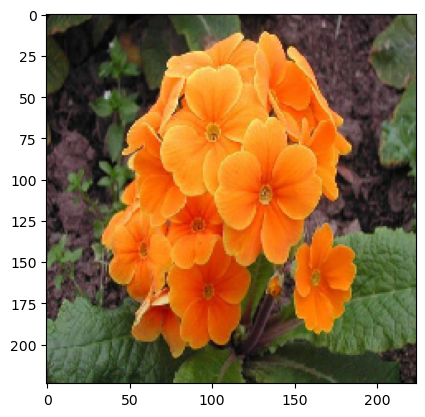

In [12]:
image=array_to_img(X_test[0])
plt.imshow(image)

In [13]:
# X_train = X_train.astype('float32') /255
# X_valid = X_valid.astype('float32') /255
# X_test = X_test.astype('float32') /255

X_test = preprocess_input(np.array(X_test))
X_valid = preprocess_input(np.array(X_valid))
X_train = preprocess_input(np.array(X_train))

print('train',X_train.shape,y_train.shape)
print('valid',X_valid.shape,y_valid.shape)
print('test',X_test.shape,y_test.shape)

train (4114, 224, 224, 3) (4114, 102)
valid (2027, 224, 224, 3) (2027, 102)
test (2048, 224, 224, 3) (2048, 102)


In [14]:
# Load the VGG19 model without the top layers (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

2023-06-20 19:03:24.322912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 19:03:24.631400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46557 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:41:00.0, compute capability: 8.9


In [15]:
# Freeze the pre-trained layers
base_model.trainable = False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# Option 1 :  No training took place....

model = Sequential([
    base_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(num_classes , activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               470118    
Total params: 20,494,502
Trainable params: 470,118
Non-trainable params: 20,024,384
_________________________________________________________________


In [22]:
# Option 2 :  training took long time, reached 0.79 accuracy after 100 epochs

# flatten the output of the convolutional part:
x = Flatten()(base_model.output)
# three hidden layers
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1000, activation='relu')(x)

predictions = Dense(num_classes, activation='softmax')(x)

# creating the full model:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
# # Option 3 :  only final dense layer with softmax #0.76
x = Flatten()(base_model.output) #Output obtained on vgg19 is now flattened.
prediction = Dense(num_classes, activation='softmax')(x) # We have 102 classes, and so, the prediction is being done
#Creating model object
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# # # option 4 : avgpooling + 1 dense layer with RELU, yielded poor performance
# 0.8669
# Add custom top layers for flower classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary())
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='vgg.png')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LR),  loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
from keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001
                              )
mcp_save = ModelCheckpoint(filepath = 'best.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [19]:
tf.config.optimizer.set_jit(True)
history=model.fit(X_train, y_train, batch_size=batch_size , callbacks=[reduce_lr,mcp_save],
                  validation_data=(X_valid, y_valid), epochs=100)

2023-06-20 19:03:27.507385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-06-20 19:03:27.935636: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-06-20 19:03:28.703045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800


 25/515 [>.............................] - ETA: 3s - loss: 8.4864 - accuracy: 0.0100    

2023-06-20 19:03:29.945934: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-20 19:03:29.947240: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


515/515 [==============================] - ETA: 0s - loss: 4.8641 - accuracy: 0.1354

2023-06-20 19:03:34.864094: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-06-20 19:03:34.892122: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


515/515 [==============================] - 9s 13ms/step - loss: 4.8641 - accuracy: 0.1354 - val_loss: 3.1614 - val_accuracy: 0.3024
Epoch 2/100
515/515 [==============================] - 6s 11ms/step - loss: 2.3576 - accuracy: 0.4543 - val_loss: 2.0422 - val_accuracy: 0.5017
Epoch 3/100
515/515 [==============================] - 5s 11ms/step - loss: 1.4271 - accuracy: 0.6449 - val_loss: 1.5097 - val_accuracy: 0.6211
Epoch 4/100
515/515 [==============================] - 5s 11ms/step - loss: 0.9447 - accuracy: 0.7669 - val_loss: 1.2276 - val_accuracy: 0.6877
Epoch 5/100
515/515 [==============================] - 6s 11ms/step - loss: 0.6723 - accuracy: 0.8337 - val_loss: 1.0639 - val_accuracy: 0.7242
Epoch 6/100
515/515 [==============================] - 6s 11ms/step - loss: 0.4877 - accuracy: 0.8887 - val_loss: 0.9748 - val_accuracy: 0.7464
Epoch 7/100
515/515 [==============================] - 6s 11ms/step - loss: 0.3661 - accuracy: 0.9212 - val_loss: 0.8939 - val_accuracy: 0.7701
Epoc

In [44]:
# # reload the model (epoch) that got best accuracy
from keras.models import load_model
best_model = load_model('/sise/home/roeiza/best.hdf5')

2023-06-26 18:46:02.054810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 18:46:08.023851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10437 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


In [21]:
# Evaluate the model on the test data
scores = best_model.evaluate(X_test, y_test, batch_size=batch_size)
#scores = model.evaluate(test_generator.flow(X_test, y_test, batch_size=batch_size))
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

 19/256 [=>............................] - ETA: 1s - loss: 1.3750 - accuracy: 0.8553

2023-06-20 19:28:54.995363: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-06-20 19:28:55.030490: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


256/256 [==============================] - 2s 6ms/step - loss: 0.9818 - accuracy: 0.8667
Test loss: 0.9818305969238281
Test accuracy: 0.86669921875


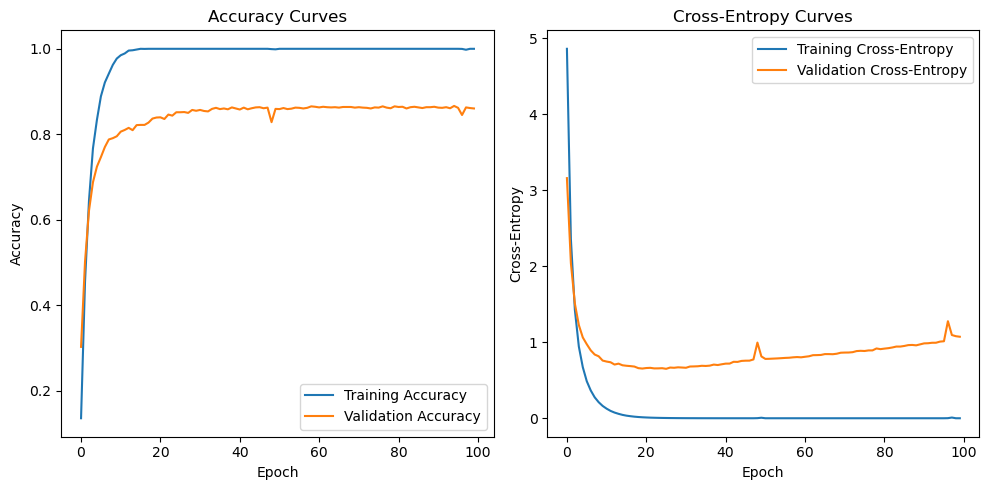

In [22]:
# from matplotlib import pyplot as plt
# Plot accuracy graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

# Plot cross-entropy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Cross-Entropy')
plt.plot(history.history['val_loss'], label='Validation Cross-Entropy')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
y_pred = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

2023-06-20 19:28:58.153675: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


Text(0.5, 23.52222222222222, 'Predicted label')

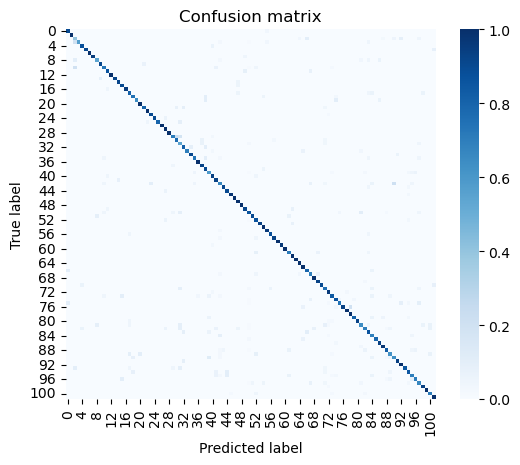

In [24]:
# # axis_labels = list(CLASSES.values())
import seaborn as sns
confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)

# Create the heatmap using seaborn
ax = sns.heatmap(confusion_normalized, cmap='Blues', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

# YOLOv5

In [25]:
########################## YOLOv5 #######################

In [47]:
list_of_labels = [str(i) for i in range(1,103)]
print(list_of_labels)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']


In [48]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
#%pip install -qr requirements.txt  # install

import torch
import utils
#display = utils.notebook_init()  # checks

fatal: destination path 'yolov5' already exists and is not an empty directory.
/sise/home/roeiza/yolov5/yolov5/yolov5


In [49]:
!rm -Rf 'flower102'
os.getcwd()

'/sise/home/roeiza/yolov5/yolov5/yolov5'

In [46]:
# arrange files in the corect folder structure
!mkdir '/sise/home/roeiza/yolov5/flower102'
for group in ['train','val','test']:
    new_group = '/sise/home/roeiza/yolov5/flower102/' + group
    if not os.path.exists(new_group):
        os.mkdir(new_group)
    if group in ['train', 'val']:
        for c in list_of_labels:
            new_dir = new_group + '/' + c
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)

df_source_image_list=pd.DataFrame(l,columns=['idx','source_img','label'])

df_x_train,df_x_test,df_y_train,df_y_test = train_test_split(df_source_image_list,df_y,test_size=0.25,random_state=42,shuffle=True,stratify=df_y)
df_x_train,df_x_valid,df_y_train,df_y_valid = train_test_split(df_x_train,df_y_train,test_size=0.33,random_state=42,shuffle=True,stratify=df_y_train)

print('train',df_x_train.shape,df_y_train.shape)
print('valid',df_x_valid.shape,df_y_valid.shape)
print('test',df_x_test.shape,df_y_test.shape)

mkdir: cannot create directory ‘/sise/home/roeiza/yolov5/flower102’: File exists
train (1029, 3) (1029, 1)
valid (507, 3) (507, 1)
test (512, 3) (512, 1)


In [27]:
# Create configuration
import yaml

config = {'path': '/sise/home/roeiza/yolov5/flowers102',
         'train': '/sise/home/roeiza/yolov5/flower102/train',
         'val': '/sise/home/roeiza/yolov5/flower102/valid',
         'nc': 102,
         'names': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101','102']
          }

with open("/sise/home/roeiza/data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [40]:
from tqdm import tqdm

In [ ]:
import os

dfs_dict = {'train': df_x_train, 'val': df_x_valid, 'test': df_x_test}
for key in dfs_dict.keys():
    df = dfs_dict[key]
    for _, row in tqdm(df.iterrows()):
        source = IMAGES_DIR + row['source_img']
        if key == 'test':
            dest1 = '/sise/home/roeiza/yolov5/flower102/' + key + '/' + row['source_img']
        else:
            dest1 = '/sise/home/roeiza/yolov5/flower102/' + key + '/' + str(row['label']) + '/' + row['source_img']
        if os.path.exists(source):
            print('moving ' + str(row) + ' from ' + str(source) + ' to ' + str(dest1))
            !mv $source $dest1
        else:
            print(f"File not found: {source}")

In [45]:
# model = torch.hub.load("ultralytics/yolov5", "yolov5s-cls")
from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

100%|██████████| 4.87M/4.87M [00:00<00:00, 11.8MB/s]

100%|██████████| 10.5M/10.5M [00:00<00:00, 22.0MB/s]

100%|██████████| 24.9M/24.9M [00:00<00:00, 31.2MB/s]

100%|██████████| 50.9M/50.9M [00:01<00:00, 41.8MB/s]

100%|██████████| 92.0M/92.0M [00:02<00:00, 38.2MB/s]



In [46]:
# # Freeze
# freeze = [f'model.{x}.' for x in range(9)]  # layers to freeze
# for k, v in model.named_parameters():
#     v.requires_grad = True  # train all layers
#     if any(x in k for x in freeze):
#         print(f'freezing {k}')
#         v.requires_grad = False

In [52]:
%cd ../yolov5
!python classify/train.py --model yolov5s-cls.pt --data /sise/home/roeiza/yolov5/flower102/ --epochs 50 --img 384 --pretrained weights/yolov5s-cls.pt

/sise/home/roeiza/yolov5/yolov5
classify/train: model=yolov5s-cls.pt, data=/sise/home/roeiza/yolov5/flower102/, epochs=50, batch_size=64, imgsz=384, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=weights/yolov5s-cls.pt, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
YOLOv5 🚀 2023-6-20 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)

TensorBoard: Start with 'tensorboard --logdir runs/train-cls', view at http://localhost:6006/
albumentations: ⚠️ no

In [53]:
!python classify/val.py --weights /sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt --data /sise/home/roeiza/yolov5/flower102/

classify/val: data=/sise/home/roeiza/yolov5/flower102/, weights=['/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
YOLOv5 🚀 2023-6-20 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
validating: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2027       0.448       0.729
                       1          10        

Inference on test

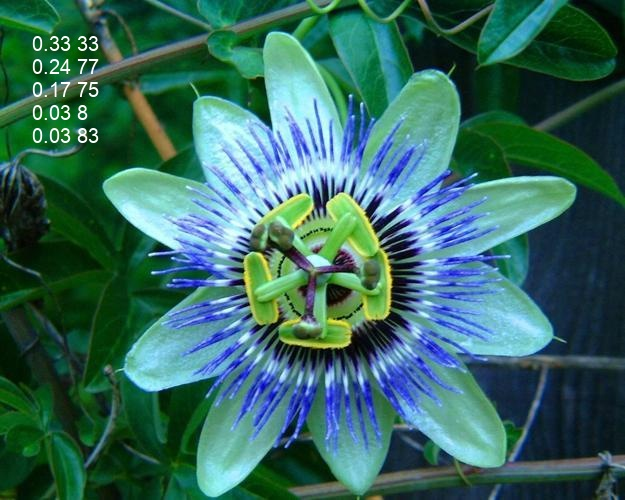

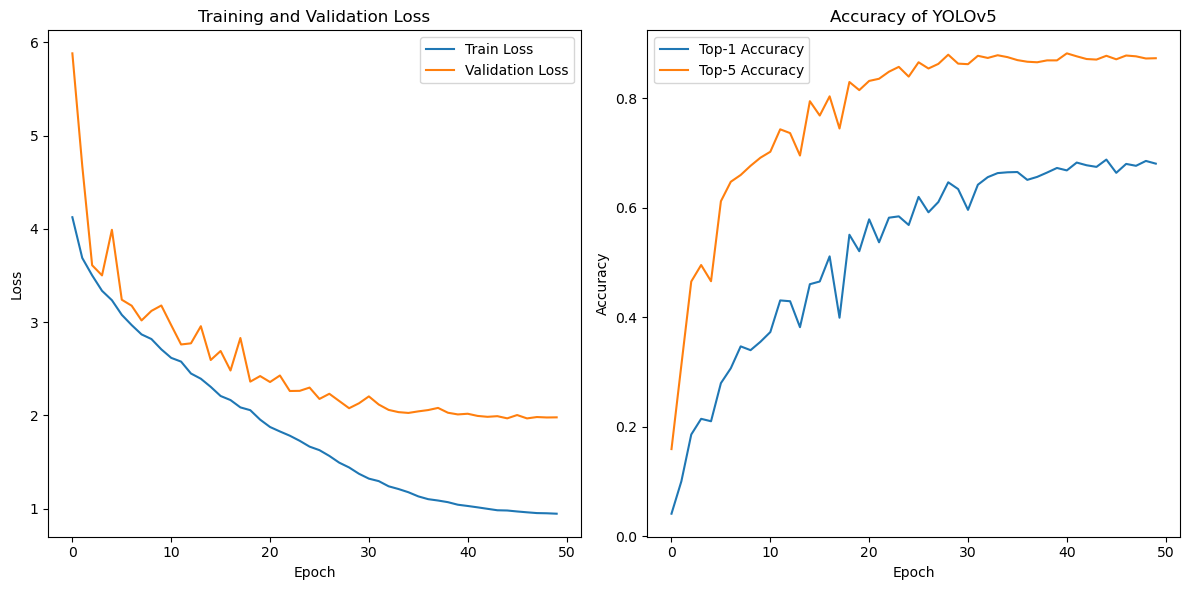

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert data to DataFrame
df = pd.read_csv('/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/results.csv', header=0)
df.columns = df.columns.str.strip()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training and Validation Loss
ax1.plot(df['epoch'], df['train/loss'], label='Train Loss')
ax1.plot(df['epoch'], df['val/loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Top-1 and Top-5 Accuracy
ax2.plot(df['epoch'], df['metrics/accuracy_top1'], label='Top-1 Accuracy')
ax2.plot(df['epoch'], df['metrics/accuracy_top5'], label='Top-5 Accuracy')
ax2.set_title('Accuracy of YOLOv5')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'custom', '/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt')
print(model)

Using cache found in /home/roeiza/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-20 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


DetectMultiBackend(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 